In [202]:
import librosa 
import mutagen
import os
import pandas as pd
import numpy as np
from pprint import pprint
import json
from mutagen.id3 import ID3
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
! ls
! echo "---------"
! ls music

music  sped_up_output.mp3  ВычмашДомашка.ipynb
---------
go.joinfile.ru.mp3    rus.hitmotop.com.mp3	  y2down.cc.mp3.mp3
muzplace.org.mp3      vk_music.mp3		  yandex_music.mp3
ru.drivemusic.me.mp3  y2down.cc_live_version.mp3


Из учебных материалов нам стало известно, как кодируется звук.
Каждый промежуток времени кодируется значение звукового сигнала. Соврменные форматы по-хитрому и уному сжимают
Закодированный звук, так как неидеальность человеческого слуха позволяет нам это делать без особых потерь.

Однако, например формат файла mp3, помимо самого звука кодирует кучу разнообразных метаданных.
Я решил поскачивать песенки с разных источников и посмотреть на то, что скрыто от глаз обычного слушателя. А также проанализировать, как метаданные влияют на вес файла.

Для начала посмотрим, как выглядит выборка данных, которую удалось получить. Анализировать мы будем композицю, являющуюся
плодом совместного творчества двух известных в узких кругах иноагентов. Для удобства данные отсортированы по возрастанию размера.

In [58]:
from pydub.utils import mediainfo

mp3_directory = "./music/"

paths = [mp3_directory + i for i in os.listdir("./music")]

def get_mutagen_info(paths_arr):
    return [mutagen.File(f) for f in paths_arr]

pydub_info = [mediainfo(p) for p in paths]
mutagen_info = get_mutagen_info(paths)
sizes = [os.path.getsize(p) for p in paths]
h_sizes = [n/2**20 for n in sizes]
sample_rates = np.array([info.info.sample_rate for info in mutagen_info])
durations = np.array([info.info.length for info in mutagen_info])
bit_rates = np.array([info.info.bitrate for info in mutagen_info])


data = pd.DataFrame({"paths":paths, 
                     "byte_file_size": sizes,
                     "human_file_size(mb)":h_sizes,
                     "duration":durations,
                     "bit_rate(Kb/s)":bit_rates/1000,
                    "sample_rate(Hz)":sample_rates}).sort_values(by="human_file_size(mb)").reset_index(drop=True)
data

,paths,byte_file_size,human_file_size(mb),duration,bit_rate(Kb/s),sample_rate(Hz)
0,./music/vk_music.mp3,4729043,4.509967,295.549388,128.0,44100
1,./music/y2down.cc.mp3.mp3,4923262,4.695189,300.251429,128.0,44100
2,./music/y2down.cc_live_version.mp3,5041122,4.807589,292.336327,128.0,44100
3,./music/go.joinfile.ru.mp3,11560840,11.025276,288.992653,320.0,44100
4,./music/muzplace.org.mp3,11562885,11.027226,289.071000,320.0,44100
5,./music/yandex_music.mp3,11587314,11.050524,288.926621,320.0,44100
6,./music/rus.hitmotop.com.mp3,11646873,11.107324,288.926621,320.0,44100
7,./music/ru.drivemusic.me.mp3,11810943,11.263793,293.057347,320.0,44100


### Вот они, слева направо, источники:
- `./music/vk_music.mp3` - скачанная с помощью телеграм-бота песня с вк музыки
- `./music/y2down.cc.mp3.mp3` - скачанный с помощью стороннего сайта mp3-файл из видео на ютубе с песней 
- `./music/y2down.cc_live_version.mp3` - кавер той же песни с другим инструменталом и аналогично предыдущему скачанный как mp3 c ютуба
- `./music/yandex_music.mp3` - скачанная с помощью расширения для браузера песня из яндекс музыки
- `./music/go.joinfile.ru.mp3`
- `./music/muzplace.org.mp3`
- `./music/rus.hitmotop.com.mp3`
- `./music/ru.drivemusic.me.mp3`
оставленные без пояснения файла были скачаны тривиальным способом с указанного сайта.

С помощью библиотеки mutagen мы извлекли основную информацию о длительности файла, битрейте (количества выделенной памяти  в секунду для
кодирования композиции), и частоты дисритезации (количества измерений значений звука в секунду). Информация о размере файла была извлеченая средствами os.

Опуская небольшие несущественные отличия в длительности композиций, немедленно обнаруживаем закономерность - файлы с бОльшим битрейтом
имеют пропорционально боОьший вес.

Попробуем самоятоятельно посчитать объем композиции и сравнить его с ранее полученным (в байтах). 

In [59]:
data["byte_our_size"] = ((data["duration"]*(data["bit_rate(Kb/s)"]*1000))/8).astype(int)
data["byte_size_diff"] = data["byte_file_size"] - data["byte_our_size"]
data[["byte_file_size", "byte_our_size", "byte_size_diff"]]

,byte_file_size,byte_our_size,byte_size_diff
0,4729043,4728790,253
1,4923262,4804022,119240
2,5041122,4677381,363741
3,11560840,11559706,1134
4,11562885,11562840,45
5,11587314,11557064,30250
6,11646873,11557064,89809
7,11810943,11722293,88650


Обнаруживаем небольшую аномалию - посчитанная нами длительность у пятого файла всего на 45 байт меньше, чем фактическая (сложно в это поверить, ведь помимо самого звука mp3-файл содержит множество дополнительной информации). Это могло произойти по разным причинам. На самом деле битрейт - это не точное значение. Существуют постоянный, переменный и усредненный битрейты (CBR, VBR, ABR). 
C - constant
V - Variable 
A - Avreage

- Постоянный битрейт задается фикисрованно для всей композиции и не меняется. Из-за того, что музыка неоднородна, такой способ не позволяет добиться оптимального соотношения между качеством и размером файла, т.к. для "тяжелых и сложных" кусков композиции размера памяти для точного кодирования может не хватать, а при записи простых, выделяется неоправданно большое количество памяти.   

- С переменным битрейтом кодек выбирает значение битрейта исходя из параметров (уровня желаемого качества), причём в течение кодируемого фрагмента битрейт может изменяться. При сжатии звука нужный битрейт определяется на основе психоакустической модели. Данный метод даёт наилучшее соотношение качество/размер выходного файла, однако точный его размер оказывается очень плохо предсказуем. В зависимости от характера звука (или изображения, в случае кодирования видео), размер полученного файла может отличаться в несколько раз. (Википедия)

- Усреднённый битрейт является гибридом постоянного и переменного битрейтов: значение в кбит/c задаётся пользователем, а программа варьирует его в некоторых пределах. Этот метод позволяет наиболее гибко задавать скорость обработки (для аудио это может быть любым числом между 8 и 320 кбит/с) и с гораздо большей (по сравнению с переменным битрейтом) точностью предсказывать размер выходного файла.

Библиотека mutagen не заморачиваетчся с VBR. Битрейт, который она возвращает, — это среднее значение по всему файлу, но в разных фрагментах песни битрейт может быть выше или ниже. Из-за этого всегда стоит понимать, что способ, которым мы сейчас посчитали размер файла (а также которым его считают школьники, когда решают задачки на егэ по информатике) через простое перемножение битрейта на длительность почти никогда не выдаст точный ответ, т.к. в современном мире не используют CBR по причине его неэффективности.


Остальные результаты выглядят вполне естественно, ведь помимо непосредственно звука, в mp3 сохраняются дополнительные данные (метаданные). Именно они составляют часть разницы между посчитанным нами и фактическим размером файла. Но что это за данные и как они влияют на размер итоговой композиции?

Для удобства отсортируем нашу табличку по возрастанию разницы и с помощью библиотеки mutagen оценим размеры метаданных ID3.

In [72]:
data = data.sort_values(by="byte_size_diff").reset_index(drop=True)
mutagen_info = get_mutagen_info(data.paths)
data["ID3_size"] = [song.tags.size for song in mutagen_info]
data[["paths", "byte_file_size", "byte_our_size", "byte_size_diff", "ID3_byte_size"]]

,paths,byte_file_size,byte_our_size,byte_size_diff,ID3_size
0,./music/muzplace.org.mp3,11562885,11562840,45,45
1,./music/vk_music.mp3,4729043,4728790,253,45
2,./music/go.joinfile.ru.mp3,11560840,11559706,1134,45
3,./music/yandex_music.mp3,11587314,11557064,30250,27609
4,./music/ru.drivemusic.me.mp3,11810943,11722293,88650,86016
5,./music/rus.hitmotop.com.mp3,11646873,11557064,89809,87040
6,./music/y2down.cc.mp3.mp3,4923262,4804022,119240,118823
7,./music/y2down.cc_live_version.mp3,5041122,4677381,363741,363324


Видим, что метаданные ID3 занимает бОльшую часть из оставшегося объема. Действительно, та разница, которую мы получили,
возникает из-за по большей части из-за того, что при подсчете мы не учитывали метаданные.

### Про ID3
ID3 (от англ. Identify an MP3) — формат метаданных, наиболее часто используемый в звуковых файлах в формате MP3. В ID3 содержатся данные о названии трека, альбома, имени исполнителя и т. д., которые используются медиаплеерами и другими программами, а также аппаратными проигрывателями для отображения информации о файле и автоматического упорядочивания аудиоколлекции. 

### Немного истории
Изначально стандарт mp3 не подддерживал хранение дополнительных данных, пока это в 1996 году не надоело Эрику Кемпу. Он предложил в конец 
файла добавлять блок из 128 байтов, в которой можно было бы хранить дополнительную информацию о песне. Так появился ID3v1. Тег v1 позволяет использовать по 30 байт для названия, исполнителя, альбома и «комментария», 4 байта для года и 1 байт для определения жанра песни из предопределенного списка значений.

Технология совершенствовалась и в 1998 году была создана принципиально новая спецификация ID3v2. Теперь тег метаданных находился в начале файла и подгружался в первую очередь. Данные ID3v2 состоят из заголовка и последующих тегов ID3. 

### Про теги

Например, в первых трех композициях записан единственный тег TSSE (именно поэтому они имеют такой маленький ID3_size), которй показывает используемый аудиокодер и его настройки, когда файл был закодирован. 

Официальное техническое описание каждого тега доступно по https://id3.org/id3v2.4.0-frames

In [110]:
print(mutagen_info[0].keys(), mutagen_info[1].keys(), mutagen_info[2].keys())

dict_keys(['TSSE']) dict_keys(['TSSE']) dict_keys(['TSSE'])



In [116]:
print("Кодировщик первой композиции: ", mutagen_info[0]["TSSE"].text[0])
print("Кодировщик второй композиции: ", mutagen_info[1]["TSSE"].text[0])
print("Кодировщик третьей композиции: ", mutagen_info[2]["TSSE"].text[0])

Кодировщик первой композиции:  Lavf58.45.100
Кодировщик второй композиции:  Lavf57.83.100
Кодировщик третьей композиции:  Lavf58.45.100


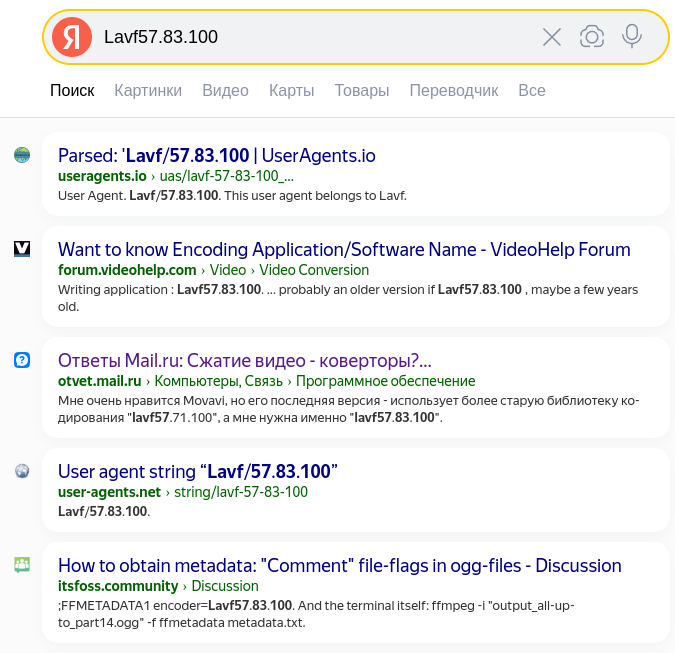


**Путем тактического гугления действительно убеждаемся, что Lavf57.83.100 - некий кодировщик**

Посмотрим другие теги. Например, возьмем второй по величине ID3_size файл с названием ./music/y2down.cc.mp3
Напомню, что это вырезанный mp3 из видео на ютубе

In [123]:
song = mutagen_info[-2]
pprint(list(song.keys()))

['TXXX:major_brand',
 'TXXX:minor_version',
 'TXXX:compatible_brands',
 'TIT2',
 'TPE1',
 'TDRC',
 'TXXX:synopsis',
 'TXXX:comment',
 'TXXX:description',
 'TSSE',
 'APIC:']


Замечаем, что у каждого тега кроме APIC присутствует буква T в начале. Идем в тех описание и читаем:

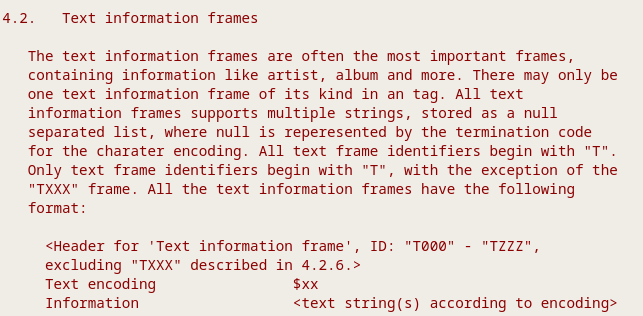

- T... - тег текстовой информации, который по большому счету может включать в себя что угодно: исполнителя, название песни, альбома и так далее.
- APIC - Attached picture - тег, содержащий обложку альбома/песни. Хранится в виде набора байто и для его чтения понадобится подключать дополнительные модули.

О значении оставшихся ID3 тегов можно почиать на оф сайте по вышеуказанной ссылке.

In [153]:
for k, v in song.items()[:-1]:
    # Выводим до 100 символа
    print("tag ", k, ": ", v.text[:50])
    print("-------------------------------")

tag  TXXX:major_brand :  ['M4A ']
-------------------------------
tag  TXXX:minor_version :  ['512']
-------------------------------
tag  TXXX:compatible_brands :  ['M4A isomiso2']
-------------------------------
tag  TIT2 :  ['Би-2 feat. Oxxxymiron - Пора возвращаться домой (Lyric Video)']
-------------------------------
tag  TPE1 :  ['oxxxymironofficial']
-------------------------------
tag  TDRC :  ['20170926']
-------------------------------
tag  TXXX:synopsis :  ['OXXXYMIRON WORLD TOUR 2023/2024: https://oxxxytour.com\n\n"Пора возвращаться домой" feat. Би-2 в Apple Music: https://apple.co/2Lj6yY8\n\n***\nArt direction and design \nLUGANSKI \nhttp://luganski.com\n\nMotion Design\nAlexey Rubischev \nhttps://www.facebook.com/alex.rubischev  \n\nRecorded at Parametrika, Moscow & by Porchy in Barcelona\nEngineered by Yurovskiy, Bolshakov\nArranged by Andrei "Bely" Lebedev\nMixed by Adrian Bushby @North London Studio, London\nMastered by Brian "Big Bass" Gardner, LA\nSound producing by 

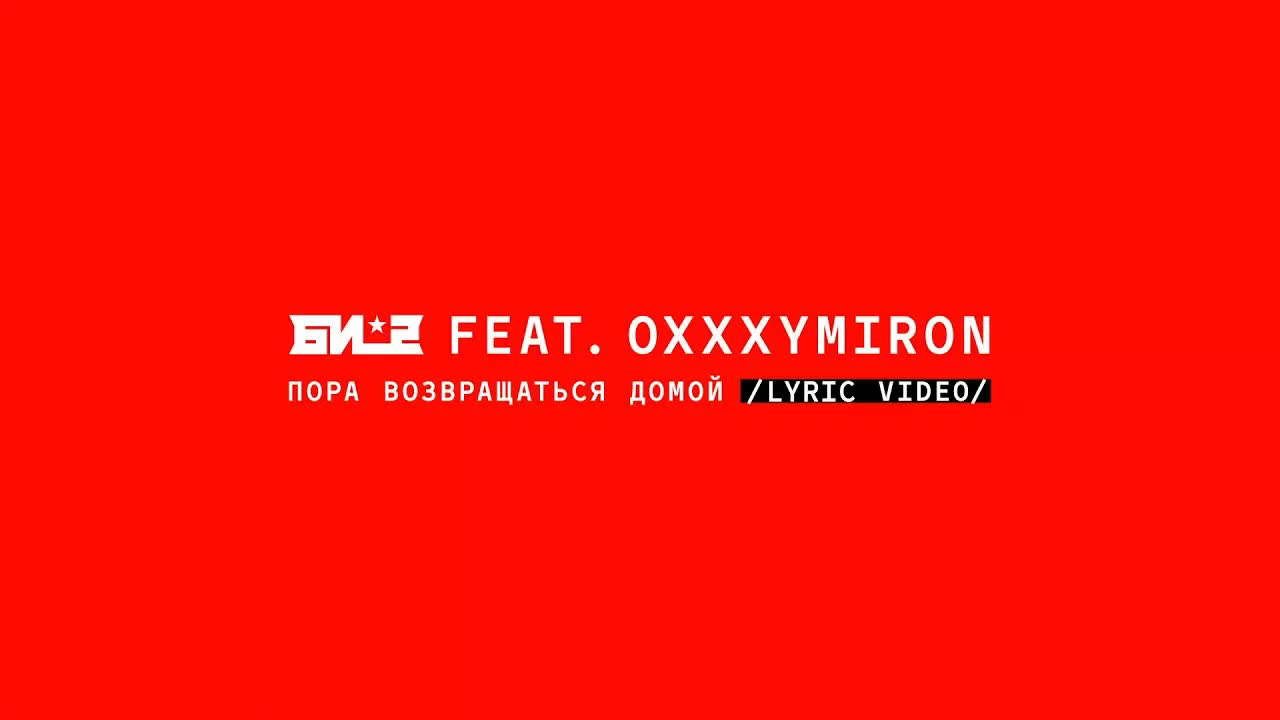

In [154]:
# Вытаскиваем обложку альбома
from PIL import Image
from io import BytesIO

pict = song["APIC:"].data
img = Image.open(BytesIO(pict))
img

А вот, например, теги, полученные при анализе четвертой аудиозаписи ./music/yandex_music.mp3

Из интересного - название альбома, жанр и порядковый номер песни в альбоме. 

In [186]:
for k, v in mutagen_info[3].items()[:-1]:
    # Выводим до 100 символа
    if  "APIC:" not in k:
        print("tag ", k, ": ", v.text[:50])
        print("-------------------------------")
    else:
        print("APIC:", v.mime)
        print("-------------------------------")

tag  TIT2 :  ['Пора возвращаться домой']
-------------------------------
tag  TPE1 :  ['Би-2/Oxxxymiron']
-------------------------------
tag  TPE2 :  ['Би-2,Oxxxymiron']
-------------------------------
tag  TALB :  ['Горизонт событий']
-------------------------------
tag  TCON :  ['rusrock']
-------------------------------
tag  TRCK :  ['8']
-------------------------------
APIC: 
-------------------------------


### Влияние на размер файла

Очевидно, что метаданные имеют вес. Давайте же посмотрим, например, влияние количества тегов ID3 на общий вес файла.
Для этого вычислим отношение ID3_size к общему весу файла, и посмотрим, как меняется это отношение в заивисмости от количества тегов.
Некоторые метаданные, такие, как, например, картинка будут гораздо тяжелее,чем текст. Поэтому также следует ввести колонку, указывающую на наличие обложки в метаданных. Также отсортируем таблицу по процентному отношению, про которое упоимналось ранее. 

In [213]:
data["ID3_part"] = round((data["ID3_size"]/data["byte_file_size"])*100, 4)
data["ID3_count"] = [len(info.keys()) for info in mutagen_info]
data["hasImage"] = [("APIC" in "".join(info.keys())) for info in mutagen_info]
data[["paths", "byte_file_size", "ID3_size", "ID3_part", "ID3_count", "hasImage"]].sort_values(by="ID3_part").reset_index(drop=True)

,paths,byte_file_size,ID3_size,ID3_part,ID3_count,hasImage
0,./music/muzplace.org.mp3,11562885,45,0.0004,1,False
1,./music/go.joinfile.ru.mp3,11560840,45,0.0004,1,False
2,./music/vk_music.mp3,4729043,45,0.0010,1,False
3,./music/yandex_music.mp3,11587314,27609,0.2383,8,True
4,./music/ru.drivemusic.me.mp3,11810943,86016,0.7283,7,False
5,./music/rus.hitmotop.com.mp3,11646873,87040,0.7473,5,True
6,./music/y2down.cc.mp3.mp3,4923262,118823,2.4135,11,True
7,./music/y2down.cc_live_version.mp3,5041122,363324,7.2072,11,True


Просто посмотрев на таблицу, заметим, что последние 3 песни с наибольним процентом метаданных ID3 имеют обложку. Также построим матрицу корреляции между количеством тегов метаданных и , за которую аналитики побьют нас палками, ведь, как известно, выборка из 8 объектов очень репрезентативна и наверняка полностью отражает положение вещей в этом мире. Но это неважно. Главное, что зависимость дополнительного веса в аудиозаписи от количества метаданных явно прослеживается. Что демнострирует высокая корреляция между  ID3_part и ID3_count. 

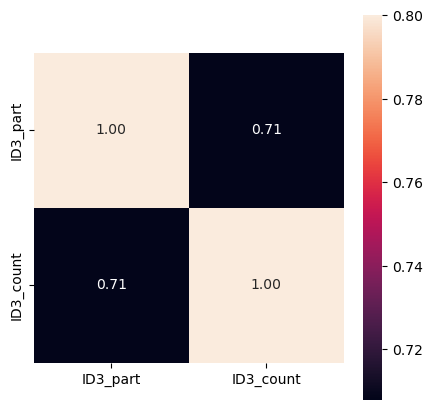

In [214]:
corrmat = data[["ID3_part", "ID3_count"]].corr()
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corrmat, vmax=.8, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10});

### Еще парочка приколов

Интересно, что в соврменных стандартах ID3 объем метаданных может быть очень большим. Это значит, что можно искуствеено раздувать размер файла путем добавления туда различного мусора. Попробуем добавить в небольшой отрывок композиции картинку очень высокого разрешения и посмотреть, как изменится размер файла после этого.

In [254]:
! ls
! echo "--------"
old_music_size = os.path.getsize("music_frag.mp3")
img_size = os.path.getsize("very_big_kartinka.jpg")
print("music_frag.mp3 size in kb:", old_size/2**10)
print("very_big_kartinka size in kb:", img_size/2**10)

music  music_frag.mp3  very_big_kartinka.jpg  ВычмашДомашка.ipynb
--------
music_frag.mp3 size in kb: 313.400390625
very_big_kartinka size in kb: 525.599609375


In [256]:
from mutagen.id3 import ID3, APIC, error
from mutagen.mp3 import MP3

audio = MP3("music_frag.mp3", ID3=ID3)

with open("very_big_kartinka.jpg", "rb") as img:
    audio.tags.add(
        APIC(
            encoding=3,  
            mime="image/jpeg",  
            type=3,  
            desc="Cover",
            data=img.read()
        )
    )
audio.save()
new_music_size = os.path.getsize("music_frag.mp3")/2**10
print("music_frag.mp3 size in mb:", new_music_size)

music_frag.mp3 size in mb: 840.3310546875


Таким образом, с помощью добавленния метаданных мы увеличили размер музыкального отрывка с 313кб до 840кб.

In [ ]:
#мяу